# Load data

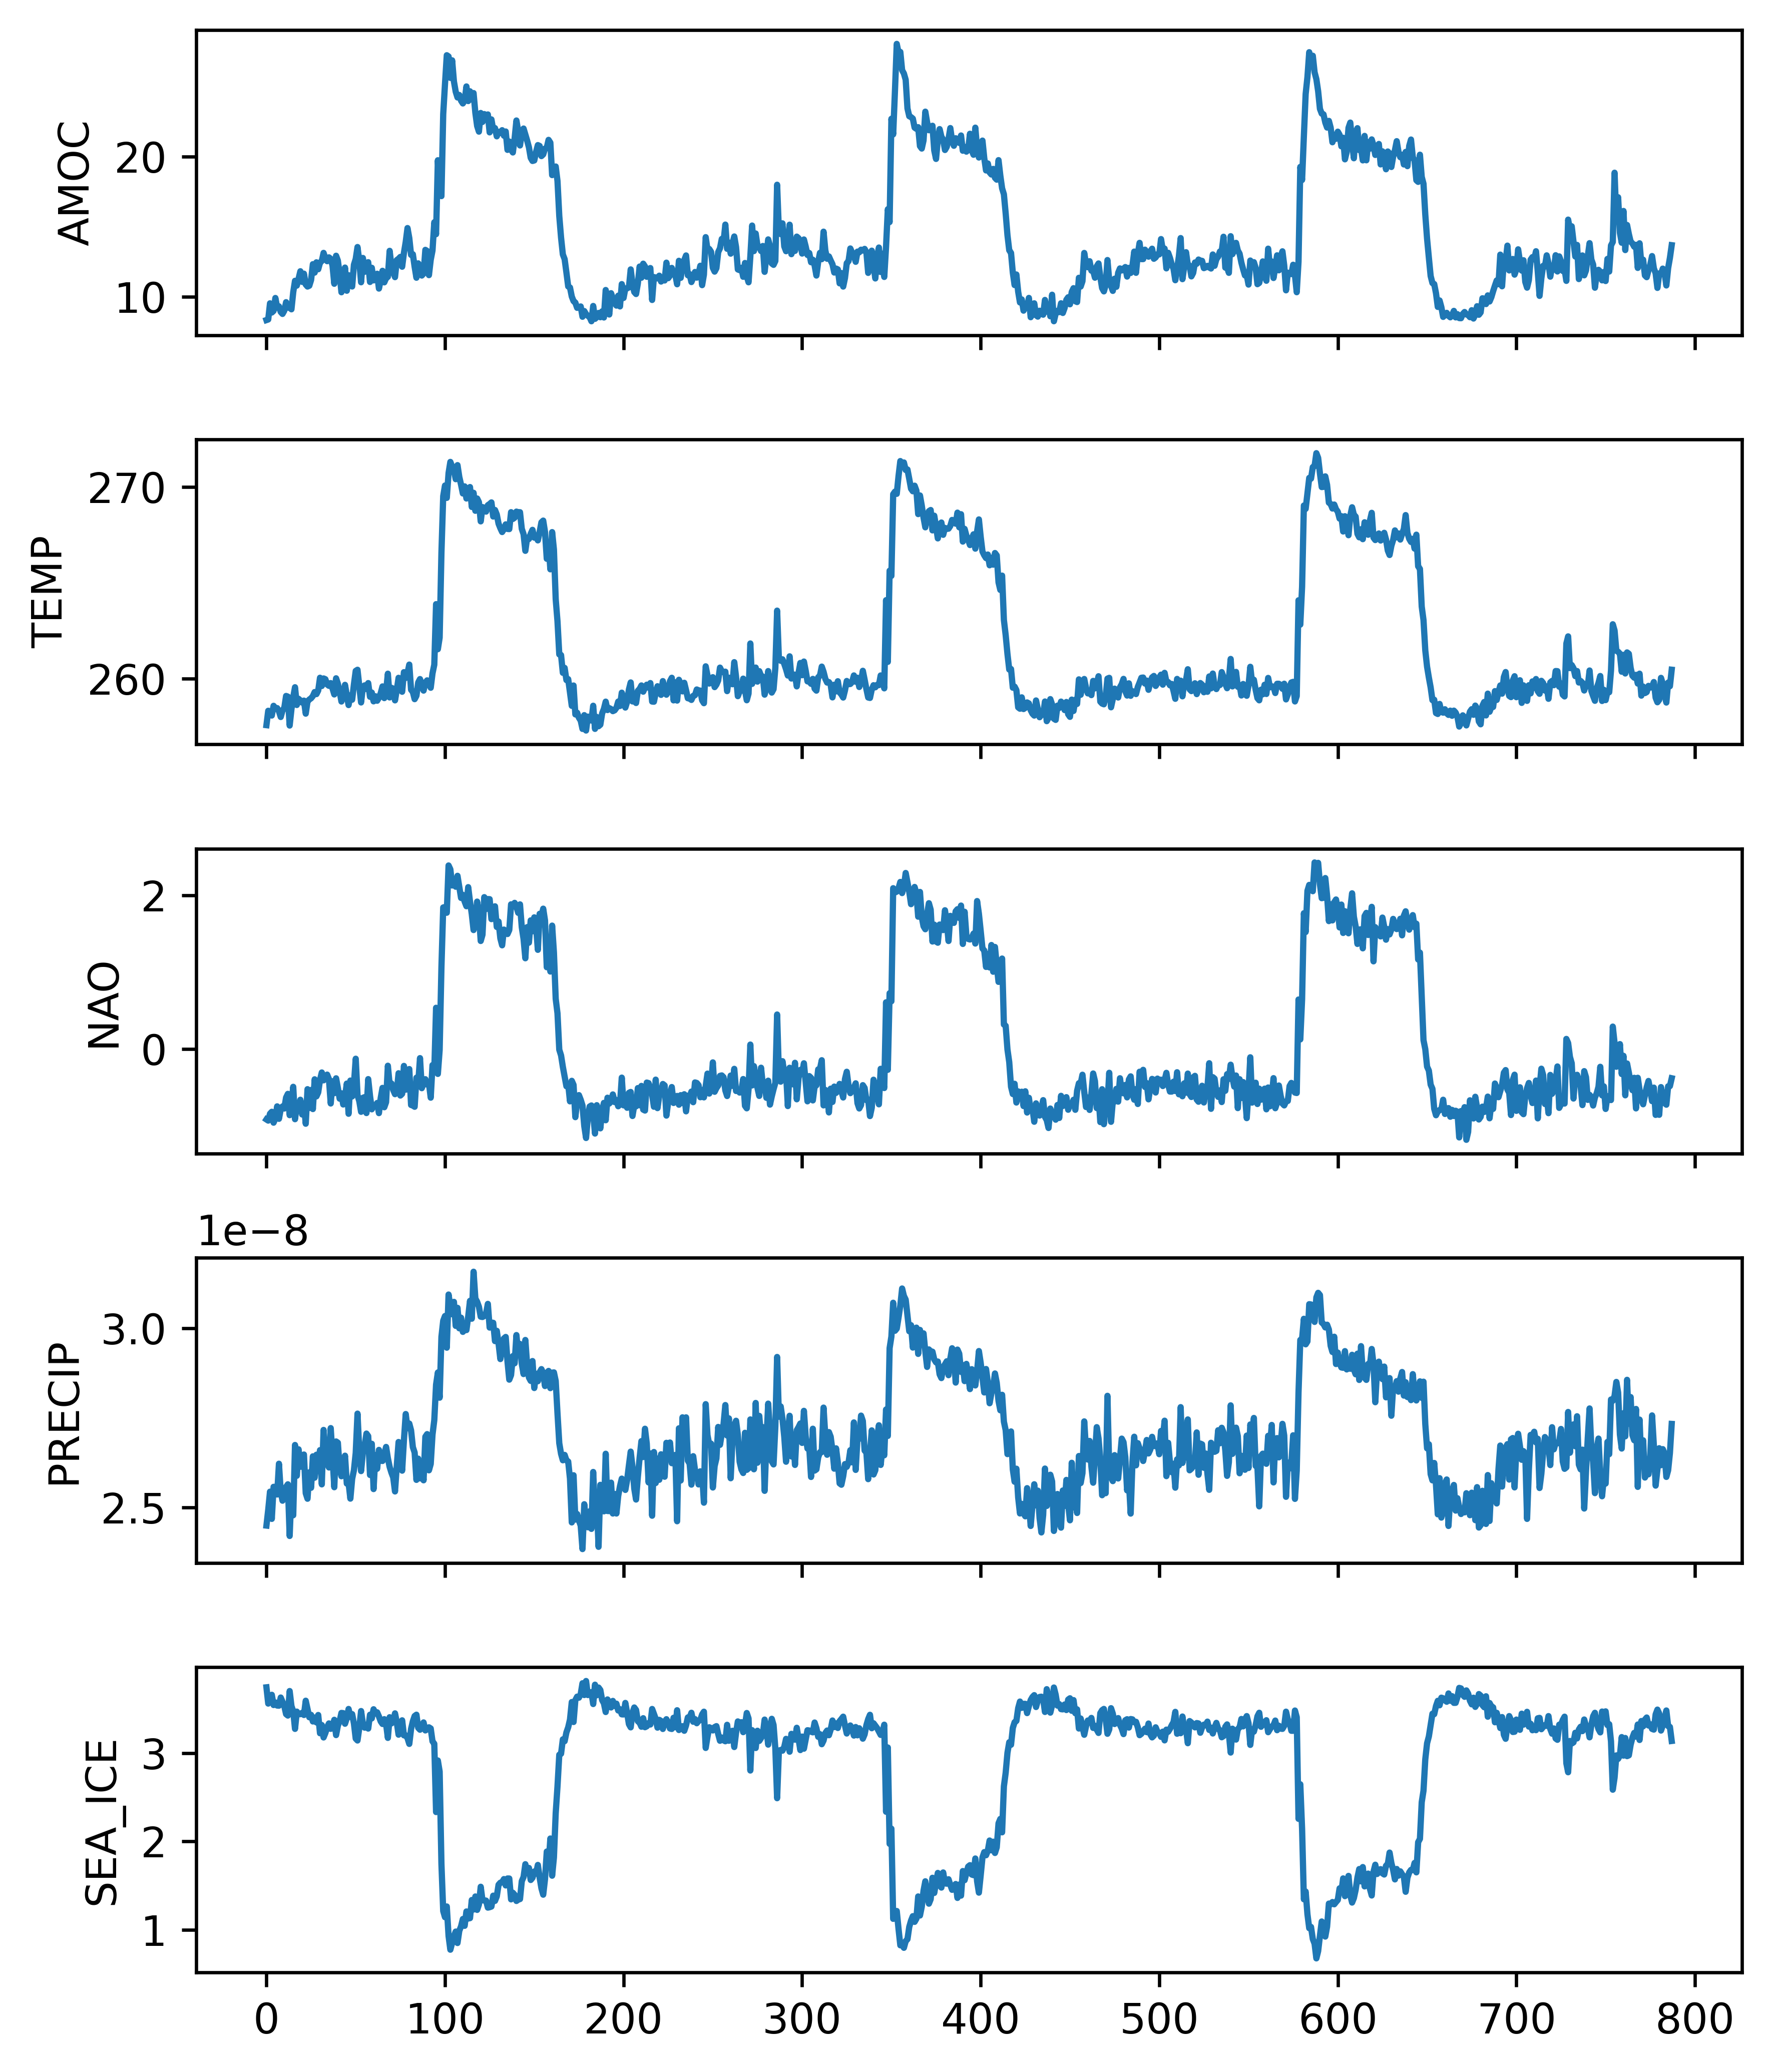

In [2]:

import numpy as np
# read the AMOC data (called '200.npy') from the /data/CCSM4/AMOC/ directory
AMOC = np.load('D:/VScode/Paleoclimate_causality/data/CCSM4/AMOC/200.npy')
TEMP = np.load('D:/VScode/Paleoclimate_causality/data/CCSM4/TEMP/200.npy')
NAO = np.load('D:/VScode/Paleoclimate_causality/data/CCSM4/NAO/200.npy')
PRECIP = np.load('D:/VScode/Paleoclimate_causality/data/CCSM4/PRECIP/200.npy')
SEA_ICE = np.load('D:/VScode/Paleoclimate_causality/data/CCSM4/SEA_ICE/200.npy')


# plot the data in 5 subplots

import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 1, figsize=(6, 7), sharex=True, dpi=600)
ax[0].plot(AMOC)
ax[0].set_ylabel('AMOC')
ax[1].plot(TEMP)
ax[1].set_ylabel('TEMP')
ax[2].plot(NAO)
ax[2].set_ylabel('NAO')
ax[3].plot(PRECIP)
ax[3].set_ylabel('PRECIP')
ax[4].plot(SEA_ICE)
ax[4].set_ylabel('SEA_ICE')
plt.tight_layout()

plt.show()


# Find warmings

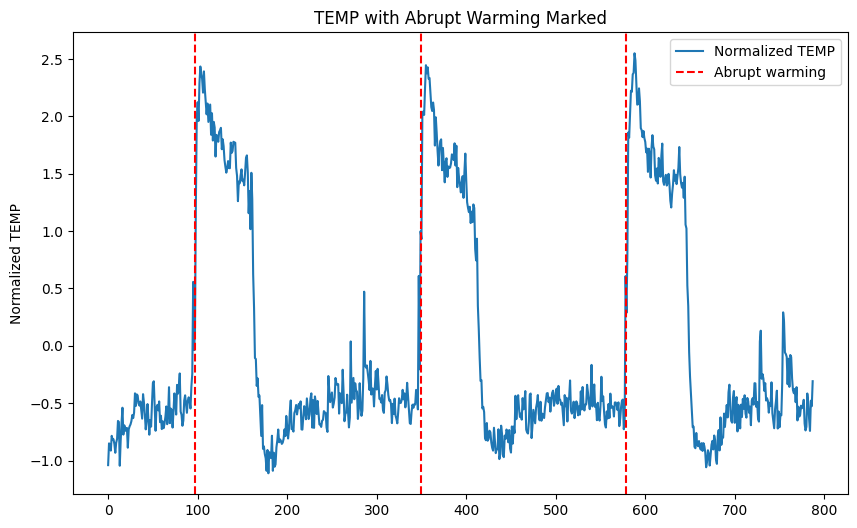

(None, [97, 350, 579])

In [15]:
# Parameters
window_size = 10
threshold = 2.5

# Normalize TEMP using z-score
TEMP_z = zscore(TEMP)

# Initialize an array to hold the midpoint indices of windows where the max-min difference exceeds the threshold
abrupt_warming_midpoints = []

# Sliding window analysis
for i in range(len(TEMP_z) - window_size + 1):
    window = TEMP_z[i:i+window_size]
    if max(window) - min(window) > threshold:
        midpoint = i + window_size // 2
        abrupt_warming_midpoints.append(midpoint)

# Step 1: Grouping the abrupt_warming_midpoints into chunks
chunks = [[abrupt_warming_midpoints[0]]]
for i in abrupt_warming_midpoints[1:]:
    if i - chunks[-1][-1] <= window_size:
        chunks[-1].append(i)
    else:
        chunks.append([i])

# Step 2: Finding the midpoint of each chunk
final_abrupt_transitions = [int(np.mean(chunk)) for chunk in chunks]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(TEMP_z, label='Normalized TEMP')
ax.set_ylabel('Normalized TEMP')
ax.set_title('TEMP with Abrupt Warming Marked')

# Plot vertical lines for final abrupt transitions
for idx in final_abrupt_transitions:
    ax.axvline(x=idx, color='r', linestyle='--', label='Abrupt warming' if idx == final_abrupt_transitions[0] else "")

ax.legend()
plt.show(), final_abrupt_transitions


In [29]:
# store the final_abrupt_transitions under /warming_ana_data 
np.save('D:/VScode/Paleoclimate_causality/warming_ana_data/TEMP_warming_trans_200.npy', final_abrupt_transitions)

In [30]:
# read the transition data (called 'TEMP_warming_200.npy') from the /warming_ana_data directory
final_abrupt_transitions = np.load('D:/VScode/Paleoclimate_causality/warming_ana_data/TEMP_warming_trans_200.npy')

# Crop data around these warming

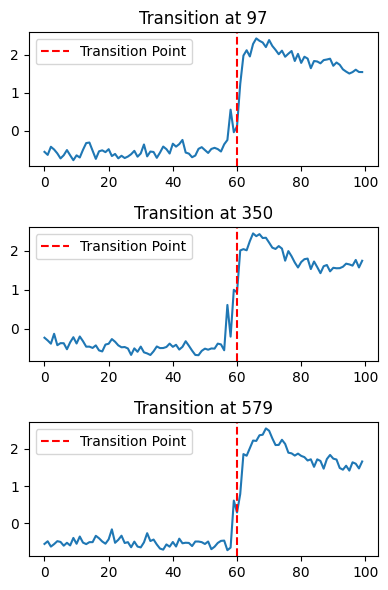

In [28]:
def crop_warming(data, transitions, left_win, right_win, plot=False):
    """
    Crop the data around given transition points and optionally plot the cropped sections.
    
    Parameters:
    - data: The dataset from which to crop sections.
    - transitions: A list of indices representing abrupt warming transitions.
    - left_win: The number of points to include before the transition.
    - right_win: The number of points to include after the transition.
    - plot: A boolean flag to enable/disable plotting of the cropped sections.
    
    Returns:
    - cropped_sections: A list of cropped sections from the dataset.
    """
    cropped_sections = []
    if plot:
        fig, axes = plt.subplots(nrows=len(transitions), figsize=(4, 2 * len(transitions)))
        if len(transitions) == 1:  # Ensure axes is always iterable
            axes = [axes]
    for i, transition in enumerate(transitions):
        start_idx = max(0, transition - left_win)
        end_idx = min(len(data), transition + right_win)
        cropped_section = data[start_idx:end_idx]
        cropped_sections.append(cropped_section)
        if plot:
            axes[i].plot(cropped_section)
            axes[i].set_title(f'Transition at {transition}')
            axes[i].axvline(x=left_win, color='r', linestyle='--', label='Transition Point')
            axes[i].legend()
    if plot:
        plt.tight_layout()
        plt.show()
    
    return cropped_sections

# Example usage of the function
left_win = 60  # Points to include before the transition
right_win = 40  # Points to include after the transition
# Plotting the first 5 transitions for demonstration
warmings=crop_warming(TEMP_z, final_abrupt_transitions, left_win, right_win, plot=True)


In [31]:
# store the cropped sections under /warming_ana_data
np.save('D:/VScode/Paleoclimate_causality/warming_ana_data/TEMP_warming_sections_200.npy', warmings)

In [32]:
# read the cropped sections (called 'TEMP_warming_sections_200.npy') from the /warming_ana_data directory
warmings = np.load('D:/VScode/Paleoclimate_causality/warming_ana_data/TEMP_warming_sections_200.npy')

# Calculate parameters

In [38]:
def optimize_piecewise_linear(time, data):
    """
    Optimized fitting of a piecewise linear function to the data with three segments.
    
    Parameters:
    - time: The time axis for the data.
    - data: The warming section data.
    
    Returns:
    - optimized_func: The optimized piecewise linear function.
    - optimized_breakpoints: The optimized breakpoints between the linear segments.
    - slopes: The slopes of the first two line segments.
    - duration: The duration of the second line segment.
    """
    
    # Define initial breakpoints based on quantiles to ensure some data in each segment
    initial_breakpoints = np.quantile(time, [1/3, 2/3])
    
    # Objective function for optimization: RMSE between data and piecewise linear model
    def objective(params):
        k1, b1, k2, b2, k3, b3 = params[:6]
        bp1, bp2 = sorted([params[6], params[7]])  # Ensure bp1 < bp2
        
        def piecewise_linear(x):
            return np.piecewise(x, [x < bp1, (x >= bp1) & (x < bp2), x >= bp2],
                                [lambda x: k1*x + b1, 
                                 lambda x: k2*(x-bp1) + (k1*bp1 + b1), 
                                 lambda x: k3*(x-bp2) + (k2*(bp2-bp1) + (k1*bp1 + b1))])
        
        fitted_values = piecewise_linear(time)
        return mean_squared_error(data, fitted_values, squared=False)
    
    # Initial guess for parameters [k1, b1, k2, b2, k3, b3, bp1, bp2]
    initial_guess = np.array([0, data.mean(), 0, data.mean(), 0, data.mean(), initial_breakpoints[0], initial_breakpoints[1]])
    
    # Constraints: bp1 and bp2 must be within the time range but not too close to each other or the boundaries
    min_distance = (time.max() - time.min()) / 10
    bounds = [(-5, 5), (data.min(), data.max()), (-5, 5), (data.min(), data.max()), (-5, 5), (data.min(), data.max()),
              (time.min() + min_distance, time.max() - 2*min_distance), (time.min() + 2*min_distance, time.max() - min_distance)]
    
    # Perform optimization
    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)
    
    if result.success:
        optimized_params = result.x
        bp1, bp2 = sorted([optimized_params[6], optimized_params[7]])
        optimized_breakpoints = [bp1, bp2]
        slopes = (optimized_params[0], optimized_params[2])
        duration = bp2 - bp1
        
        def optimized_func(x):
            k1, b1, k2, _, k3, _ = optimized_params[:6]
            return np.piecewise(x, [x < bp1, (x >= bp1) & (x < bp2), x >= bp2],
                                [lambda x: k1*x + b1, 
                                 lambda x: k2*(x-bp1) + (k1*bp1 + b1), 
                                 lambda x: k3*(x-bp2) + (k2*(bp2-bp1) + (k1*bp1 + b1))])
        
        return optimized_func, optimized_breakpoints, slopes, duration
    else:
        raise ValueError("Optimization failed. Try different initial conditions or check the data.")




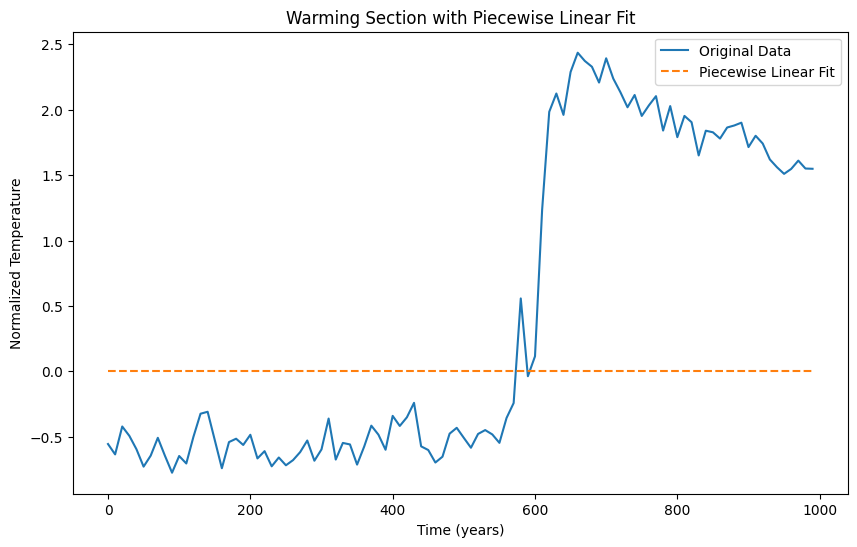

IndexError: invalid index to scalar variable.

In [39]:

warming_section = warmings[0]  # For demonstration, using the first section

# Assigning a time axis with a step of 10 years
time = np.arange(0, len(warming_section) * 10, 10)

# Fit the piecewise linear function to the warming section
piecewise_func, breakpoints, slopes, duration = optimize_piecewise_linear(time, warming_section)

# Plotting the original data and the fitted piecewise function
plt.figure(figsize=(10, 6))
# Correcting and completing the plotting command
plt.plot(time, warming_section, label='Original Data')
plt.plot(time, piecewise_func(time), label='Piecewise Linear Fit', linestyle='--')
for bp in breakpoints[1:-1]:  # Skipping the first and last because they are artificial bounds
    plt.axvline(x=bp, color='r', linestyle=':', label='Breakpoint' if bp == breakpoints[1] else None)
plt.legend()
plt.title('Warming Section with Piecewise Linear Fit')
plt.xlabel('Time (years)')
plt.ylabel('Normalized Temperature')
plt.show()

# Calculating the residual between the warming data and the piecewise fit
residual = warming_section - piecewise_func(time)

# Fit an AR1 model to the residual
ar1_model = sm.tsa.ARIMA(residual, order=(1, 0, 0)).fit()

# Output requested details
slope_first_line = slopes[0]
slope_second_line = slopes[1]
time_duration_second_line = duration[1]
ar1_params = ar1_model.params

slope_first_line, slope_second_line, time_duration_second_line, ar1_params

In [41]:
warming_section = warmings[0]  # For demonstration, using the first section
warming_section

array([-0.55518061, -0.63444642, -0.42122225, -0.49286469, -0.59521878,
       -0.72804435, -0.64400155, -0.50771709, -0.6449019 , -0.77452947,
       -0.64671448, -0.70392597, -0.50081031, -0.32365604, -0.30877549,
       -0.52454724, -0.74026054, -0.54024977, -0.5146259 , -0.5623541 ,
       -0.48449136, -0.66524357, -0.60967377, -0.72554882, -0.65826519,
       -0.71771915, -0.67828419, -0.61707105, -0.52835306, -0.68287222,
       -0.59636932, -0.36047547, -0.67394569, -0.54685505, -0.5583857 ,
       -0.7124646 , -0.57423384, -0.41487278, -0.48379436, -0.59898052,
       -0.3401052 , -0.4172044 , -0.35093989, -0.24047508, -0.57303183,
       -0.6011001 , -0.69664932, -0.65207876, -0.47603867, -0.43136806,
       -0.50828481, -0.58366449, -0.47826783, -0.44865551, -0.48187166,
       -0.54631146, -0.35633783, -0.24193267,  0.55735055, -0.0371241 ,
        0.11507624,  1.23355113,  1.9833426 ,  2.12333203,  1.95999906,
        2.28790097,  2.43500558,  2.37206626,  2.32775184,  2.20